In [56]:
from ThesisPackage.Environments.pong.multi_pong_sender_receiver_ball_onehot import PongEnvSenderReceiverBallOneHot
from ThesisPackage.RL.Centralized_PPO.multi_ppo import PPO_Multi_Agent_Centralized
from ThesisPackage.RL.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
from ThesisPackage.Wrappers.vecWrapper import PettingZooVectorizationParallelWrapper
import torch
import numpy as np
import time
import os

In [57]:
def make_env():
    sequence_length = 1
    vocab_size = 3
    max_episode_steps = 512
    env = PongEnvSenderReceiverBallOneHot(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_episode_steps=max_episode_steps)
    # env = ParallelFrameStack(env, 4)
    return env

In [58]:
def load(path="models/checkpoints"):
    env = make_env()
    models = {}
    for model in os.listdir(path):
        if "checkpoint" in model:
            state_dict = torch.load(os.path.join(path, model))
            timestamp = model.split("_")[-1]
            timestamp = int(timestamp.split(".")[0])
            agent = PPO_Multi_Agent_Centralized(env, device="cpu")
            agent.agent.load_state_dict(state_dict)
            models[timestamp] = agent
    return models

In [72]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

def plot_language_saliencies(env, full_saliences, path=None, sequence_length=1, vocab_size=3):
    plt.figure(figsize=(20, 5))  # Adjust figure size to make it more readable

    plot_saliences = full_saliences.reshape(full_saliences.shape[0], -1)

    # Sum up the saliencies of the one-hot encoded language channels
    for i in range(sequence_length):

        start_index = -(i + 1) * env.vocab_size

        current_data = np.max(plot_saliences[:, start_index::-(i + 1) * env.vocab_size], axis=1)
        # current_data = np.sum(plot_saliences[:, i * vocab_size::(i+1) * vocab_size], axis=1)
        plt.plot(current_data, label=f'Channel {i+1}')

    ax = plt.gca()
    ax.set_xlim([0, len(plot_saliences)])

    # plt.plot(saliencies)
    plt.title('Saliency of language channel')
    plt.xlabel('Timestep')
    plt.ylabel('Saliency Sum')
    plt.legend()
    if path != None:
        plt.savefig(path)
    else:
        plt.show()

In [60]:
def plot_saliencies(full_saliencies, path=None, title="Heatmap for one epoch"):
    # Transposing the reshaped data for desired orientation
    data_reshaped = full_saliencies.reshape(-1, full_saliencies.shape[2])
    data_transposed = data_reshaped.T

    sequence_length = 1
    vocab_size = 3

    # Plotting the heatmap with the new orientation
    plt.figure(figsize=(15, 7))
    plt.imshow(data_transposed, aspect='auto', cmap='viridis')
    plt.colorbar(label='Values')
    plt.title(title)
    plt.xlabel('Timestep')
    plt.ylabel('Features')

    red_line = mlines.Line2D([], [], color='red', label='Language Channel')

    # Adding a red box around the last two features (4 and 5)
    rect = plt.Rectangle((-0.1, 9.5), data_reshaped.shape[0] - 0.9, sequence_length * vocab_size - 0.1, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)

    plt.legend(handles=[red_line])

    if path != None:
        plt.savefig(path)
    else:
        plt.show()

In [61]:
def integrated_gradients(inputs, model, target_label_idx, baseline=None, steps=100):
    if baseline is None:
        baseline = torch.zeros_like(inputs)
    assert baseline.shape == inputs.shape
    
    grads = []

    for i in range(steps):
        scaled_input = torch.tensor(baseline + (float(i) / steps) * (inputs - baseline), requires_grad=True)
        # scaled_input.requires_grad = True
        logits = model(scaled_input)
        loss = logits[0, target_label_idx]
        loss.sum().backward()
        grads.append(scaled_input.grad.data.cpu().numpy())

    avg_grads = np.average(grads, axis=0)
    integrated_grad = (inputs.detach().cpu().numpy() - baseline.cpu().numpy()) * avg_grads

    return integrated_grad

In [62]:
def get_means(agent, env, epochs):
    means = []
    tokens = {channel: {0: 0, 1: 1, 2: 2} for channel in [1, 2]}
    for i in range(epochs):
        obs, info = env.reset()
        state = env.state()
        while True:
            obs = [obs]
            state = [state]
            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))
            means.append(obs)
            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                action, _, _, _ = agent.agent.get_action_and_value(obs, state)
                action = reverse_flatten_list_with_agent_list(action, agent.agents)
            obs, rewards, terminations, truncations, info = env.step(action[0])
            state = env.state()
            for channel in [1, 2]:
                for paddle in env.agents:
                    cur_token = int(obs[paddle][-1 * channel])
                    tokens[channel][cur_token] += 1
            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                break
    means = np.stack(means)
    return means, tokens

In [63]:
import copy

def record_data(env, data):
    data["ball_1"].append(copy.deepcopy(env.balls["ball_1"]["position"]))
    data["ball_2"].append(copy.deepcopy(env.balls["ball_2"]["position"]))
    data["direction_1"].append(copy.deepcopy(env.balls["ball_1"]["direction"]))
    data["direction_2"].append(copy.deepcopy(env.balls["ball_2"]["direction"]))
    data["paddle_1"].append(copy.deepcopy(env.paddles["paddle_1"]))
    data["paddle_2"].append(copy.deepcopy(env.paddles["paddle_2"]))
    data["distances"].append(copy.deepcopy(abs(env.paddles["paddle_1"] - env.paddles["paddle_2"])))
    return data

In [64]:
def test(agent, env, timesteps=1024, sequence_length=1, vocab_size=3, tracking_agent="paddle_1"):
    saliencies = []
    full_saliences = []
    obs, info = env.reset()
    state = env.state()
    average_length = []
    tokens = []
    data = {"ball_1": [], "ball_2": [], "direction_1":[], "direction_2":[], "paddle_1": [], "paddle_2": [], "distances":[]}
    
    for timestep in range(timesteps):
            
        traking_index = env.agents.index(tracking_agent)
        tokens.append(obs[tracking_agent][-1 * env.sequence_length:])
        obs = [obs]
        state = [state]
        obs = np.array(flatten_list(obs))
        state = np.array(flatten_list(state))

        data = record_data(env, data)

        obs_track = torch.tensor(np.expand_dims(obs[traking_index], axis=0), dtype=torch.float32, requires_grad=True)
        logits = agent.agent.actor(obs_track)

        grad_tensor = torch.zeros_like(logits)
        grad_tensor[:, :-1 * sequence_length * vocab_size] = 1

        logits.backward(grad_tensor)

        saliency = obs_track.grad.data.abs()

        saliency = saliency.numpy()
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

        average_language = np.sum(saliency[:, -1 * sequence_length * vocab_size:])

        obs = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
            actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

        actions = actions[0]
        actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

        saliencies.append(average_language)
        full_saliences.append(saliency)

        obs, _, truncations, terminations, infos = env.step(actions)
        state = env.state()

        if any([truncations[agent] or terminations[agent] for agent in env.agents]):
            average_length.append(timestep)
            obs, info = env.reset()
    full_saliences = np.stack(full_saliences, axis=0)
    return saliencies, average_length, full_saliences, np.array(tokens), data

In [65]:
def test_integrated_gradients(agent, env, means, smaller = True , threshold = 0.5, noise=False, epochs=1, tracking_agent="paddle_1"):
    saliencies = []
    full_saliences = []
    obs, info = env.reset()
    state = env.state()
    average_length = []
    average_noise_share = []
    tokens = []

    data = {"ball_1": [], "ball_2": [], "direction_1":[], "direction_2":[], "paddle_1": [], "paddle_2": [], "distances":[]}
    for i in range(epochs):
        print(f"Epoch {i} out of {epochs}")
        timestep = 0
        noises = []
        while True:
            timestep += 1
            traking_index = env.agents.index(tracking_agent)
            tokens.append(obs[tracking_agent][-1 * env.sequence_length:])
            obs = [obs]
            state = [state]
            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))

            data = record_data(env, data)

            obs_track = torch.tensor(np.expand_dims(obs[traking_index], axis=0), dtype=torch.float32, requires_grad=True)
            
            baselines = torch.tensor(np.expand_dims(means, axis=0), dtype=torch.float32)
            baselines[0] = 9.0
            
            # integrated_grads = smoothgrad(obs_track, agent.agent.actor, 0, sigma=1.0, steps=30)
            integrated_grads = integrated_gradients(obs_track, agent.agent.actor, [0, 1, 2], baseline=baselines, steps=20)

            # integrated_grads = (integrated_grads - integrated_grads.min()) / (integrated_grads.max() - integrated_grads.min())
            language_saliences = np.sum(integrated_grads[0, -1 * env.sequence_length:])

            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
                actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

            actions = actions[0]
            actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

            saliencies.append(language_saliences)
            full_saliences.append(integrated_grads)

            obs, _, truncations, terminations, infos = env.step(actions)
            state = env.state()

            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                average_length.append(timestep)
                obs, info = env.reset()
                state = env.state()
                break
        average_noise_share.append(np.mean(noises))
    full_saliences = np.stack(full_saliences, axis=0)
    return saliencies, average_length, full_saliences, np.mean(average_noise_share), np.array(tokens), data

In [66]:
num_steps = 10000
agents = load("/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/saliencies_live/Multi_Pong/Sequence_Length_1")
agent_indizes = list(agents.keys())
agent_indizes.sort()
env = make_env()

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [67]:
means, tokens = get_means(agents[agent_indizes[-1]], env, 100)
means = means.reshape(-1, means.shape[-1])
means = np.mean(means, axis=0)

In [68]:
# saliencies, average_length, full_saliences, _, tokens, data = test_integrated_gradients(agents[agent_indizes[-1]], env, means, epochs=1)

In [69]:
saliencies, average_length, full_saliences, tokens, data = test(agents[agent_indizes[-1]], env, timesteps=256, tracking_agent="paddle_1")

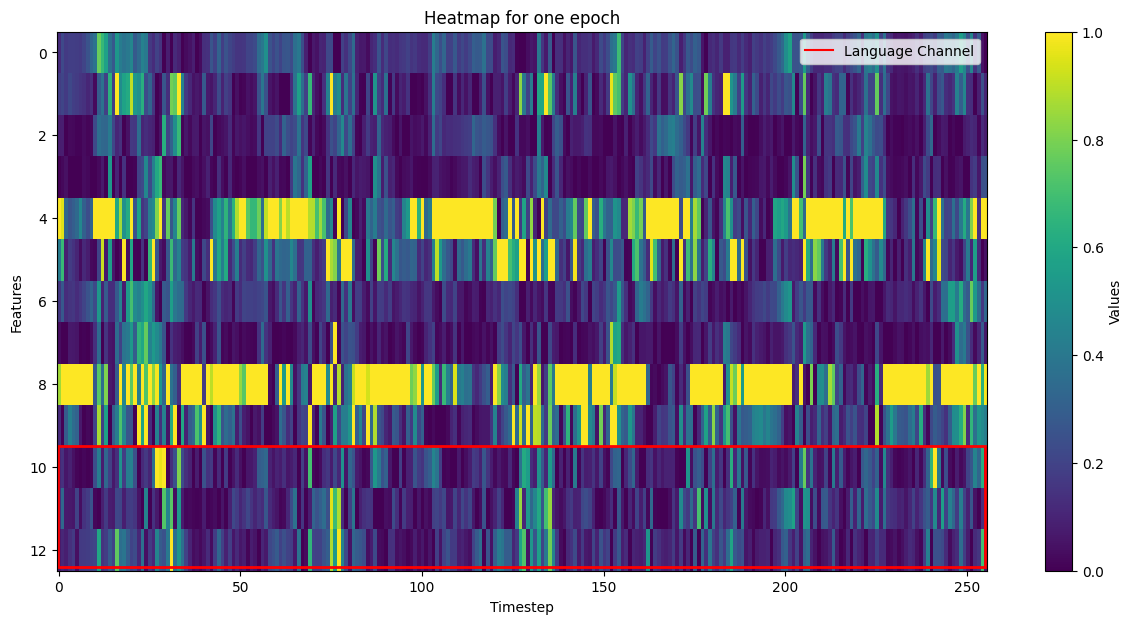

In [74]:
plot_saliencies(full_saliences)

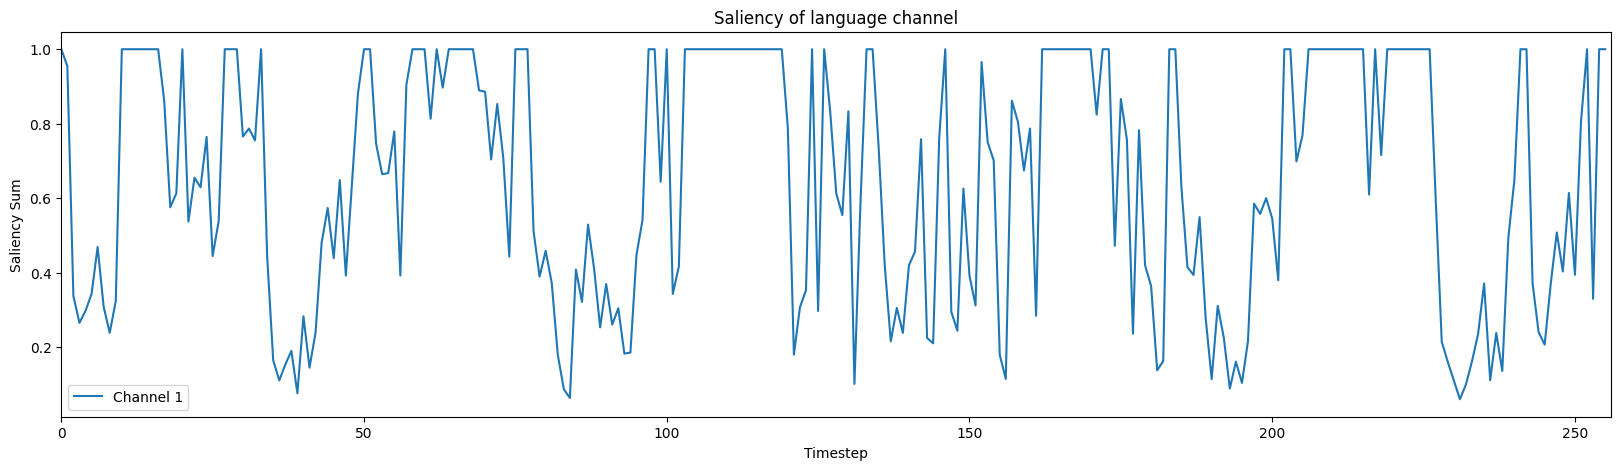

In [75]:
plot_language_saliencies(env, full_saliences, sequence_length=1)

[4, 2, 0, 0, 2, 2, 2, 2, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 3, 3, 4, 2, 2, 2, 0, 1, 1, 1, 2, 3, 3, 5, 6, 5, 4, 5, 4, 3, 3, 2, 3, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 3, 3, 2, 1, 1, 0, 1, 1, 1, 2, 2, 2, 3, 4, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 1, 1, 3, 2, 2, 2, 3, 2, 3, 3, 4, 3, 3, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 1, 2, 0, 0, 0, 1, 2, 3, 3, 2, 3, 3, 2, 1, 1, 3, 4, 4, 5, 5, 4, 6, 6, 6, 6, 4, 4, 4, 4, 3, 3, 3, 3, 3, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 2, 3, 4, 3, 4, 4, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 3, 3, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 2, 4, 3, 2, 2, 4, 6, 6, 8, 10, 12, 14, 14, 16, 16, 17, 16, 15, 15, 14, 15, 13, 13, 12, 

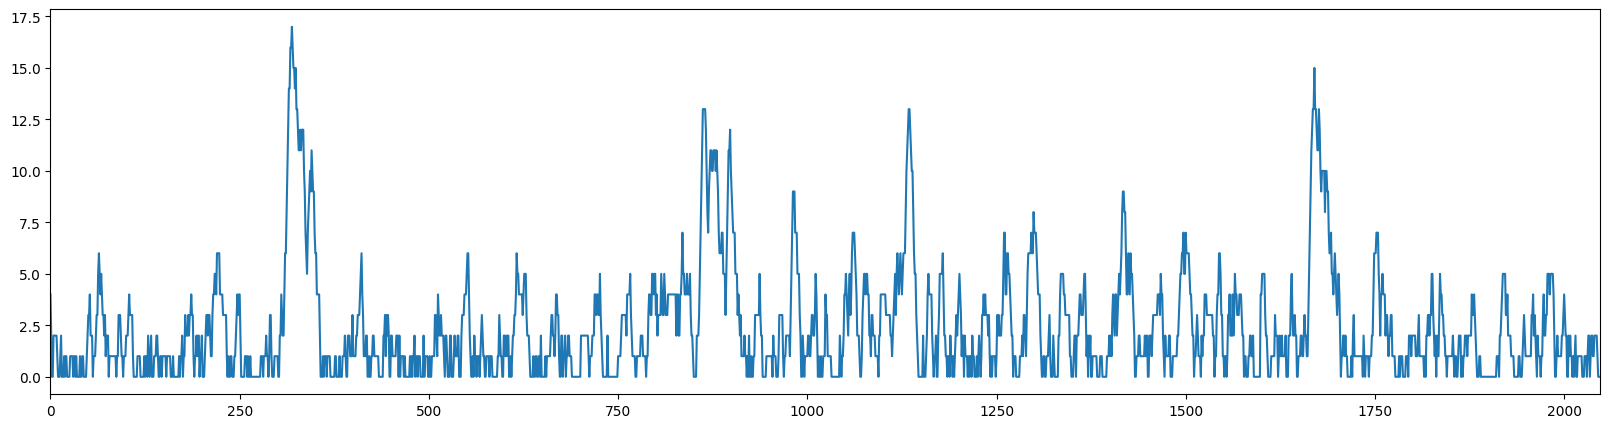

In [40]:
print(data["distances"])

plt.figure(figsize=(20, 5))
ax = plt.gca()
ax.set_xlim([0, len(data["distances"])])
plt.plot(data["distances"])
plt.show()

In [ ]:
plot_saliences = full_saliences.reshape(full_saliences.shape[0], -1)

for i in range(env.sequence_length):
    current_data = np.max(plot_saliences[:, i * env.vocab_size::(i+1) * env.vocab_size], axis=1)
    indices = np.argsort(current_data)[-10:]

In [42]:
# Assuming full_saliences is already defined and env.sequence_length and env.vocab_size are available
plot_saliences = full_saliences.reshape(full_saliences.shape[0], -1)

for i in range(env.sequence_length):
    # Calculate the start index from the end using negative indexing
    start_index = -(i + 1) * env.vocab_size
    
    # Slice the array from the end and calculate the max along axis=1
    current_data = np.max(plot_saliences[:, start_index::-(i + 1) * env.vocab_size], axis=1)
    
    # Ensure that values go to -1 if 0 would be the number
    current_data[current_data == 0] = -1
    
    # Get the last 10 indices by sorting in ascending order (multiplying by -1)
    indices = np.argsort(-current_data)[-10:]

In [43]:
import pygame

pygame.init()
window_size = 600  # Set the size of the window
cell_size = window_size // max(env.width, env.height)
screen = pygame.display.set_mode((env.width * cell_size, env.height * cell_size))
pygame.display.set_caption('Pong Environment')
clock = pygame.time.Clock()

def render_pygame(env, data, index, mode='pygame'):
    # Initialize PyGame if variable already exists

    # Set screen background and basic colors
    screen.fill((0, 0, 0))  # Black background
    paddle_color = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # Colors for paddles

    # Draw paddles
    paddle_width = cell_size
    paddle_height = cell_size * env.paddle_height

    paddles = {"paddle_1": data["paddle_1"][index], "paddle_2": data["paddle_2"][index]}
    balls = {"ball_1":
              {"position": data["ball_1"][index], "direction": data["direction_1"][index]},
             "ball_2":
              {"position": data["ball_2"][index], "direction": data["direction_2"][index]}
            }

    for i, paddle in enumerate(paddles.keys()):
        paddle_pos = paddles[paddle]

        pygame.draw.rect(screen, paddle_color[i], pygame.Rect((env.width * cell_size - cell_size, paddle_pos * cell_size), (paddle_width, paddle_height)))

    # Draw balls
    for ball in balls.keys():
        ball_pos = [cur_pos  * cell_size for cur_pos in balls[ball]["position"]]
        ball_direction = balls[ball]["direction"]
        pygame.draw.circle(screen, (255, 255, 255), ball_pos, 10)
        pygame.draw.line(screen, paddle_color[i], ball_pos, (ball_pos[0] + ball_direction[0] * 30, ball_pos[1] + ball_direction[1] * 30), 10)

    # Update the display
    pygame.display.flip()

    # Handle quitting from the window
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()

In [44]:
while True:
    for index in indices:
        render_pygame(env, data, index)
        time.sleep(1.0)

KeyboardInterrupt: 

: 